<h1>M. Nielsen, Chapter 6, expand data set and dropout</h1>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import numpy as np
import time
import random
from winsound import Beep


In [4]:
import tensorflow as tf # changed to intel-optimized build
Beep(1000, 100)

In [6]:
from matplotlib import pyplot as plt

In [7]:
os.chdir(r"C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter3\20211119\multi_layer")

<h1>load data & expand training data</h1>

In [8]:
###############################################
#    load data from local directory
###############################################

import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
Beep(1000, 100)

###############################################
#    expand training data
###############################################
expanded_training_pairs = []
j = 0 # counter
for data in training_data:
    x = data[0]
    y = data[1]
    expanded_training_pairs.append((x, y))
    image = x.reshape((28, 28))
    j += 1
    if j % 1000 == 0: print("Expanding image number", j)
    # iterate over data telling us the details of how to
    # do the displacement
    for d, axis, index_position, index in [
            (1,  0, "first", 0),
            (-1, 0, "first", 27),
            (1,  1, "last",  0),
            (-1, 1, "last",  27)]:
        new_img = np.roll(image, d, axis)
        if index_position == "first": 
            new_img[index, :] = np.zeros(28)
        else: 
            new_img[:, index] = np.zeros(28)
        expanded_training_pairs.append((np.reshape(new_img, 784), y))
# random.shuffle(expanded_training_pairs)
expanded_training_data = [list(d) for d in expanded_training_pairs]



Expanding image number 1000
Expanding image number 2000
Expanding image number 3000
Expanding image number 4000
Expanding image number 5000
Expanding image number 6000
Expanding image number 7000
Expanding image number 8000
Expanding image number 9000
Expanding image number 10000
Expanding image number 11000
Expanding image number 12000
Expanding image number 13000
Expanding image number 14000
Expanding image number 15000
Expanding image number 16000
Expanding image number 17000
Expanding image number 18000
Expanding image number 19000
Expanding image number 20000
Expanding image number 21000
Expanding image number 22000
Expanding image number 23000
Expanding image number 24000
Expanding image number 25000
Expanding image number 26000
Expanding image number 27000
Expanding image number 28000
Expanding image number 29000
Expanding image number 30000
Expanding image number 31000
Expanding image number 32000
Expanding image number 33000
Expanding image number 34000
Expanding image number 

In [9]:
###############################################
#    convert data format
###############################################

train_x, train_y, val_x, val_y, test_x, test_y = [], [], [], [], [], []

for tra in expanded_training_data:
    img_tra_x = tra[0].reshape(28,28).tolist()
    img_tra_y = np.array(np.argmax(tra[1]), dtype=np.uint8)
    train_x.append(img_tra_x)
    train_y.append(img_tra_y)
print(np.shape(train_x))

for val in validation_data:
    img_val_x = val[0].reshape(28,28)
#     img_val_y = np.array(np.argmax(val[1]), dtype=np.uint8)
    img_val_y = np.array(val[1], dtype=np.uint8)
    val_x.append(img_val_x)
    val_y.append(img_val_y)
print(np.shape(val_x))

for tes in test_data:
    img_tes_x = tes[0].reshape(28,28)
    img_tes_y = np.array(tes[1], dtype=np.uint8)
    test_x.append(img_tes_x)
    test_y.append(img_tes_y)
print(np.shape(test_x))


train_x = np.array(train_x)
val_x = np.array(val_x)
test_x = np.array(test_x)

train_y = np.array(train_y)
val_y = np.array(val_y)
test_y = np.array(test_y)

Beep(1000, 100)

(250000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


In [14]:
# ###############################################
# #    checking expanded data
# ###############################################

# for i in range(5):
#     plt.imshow(train_x[i], interpolation='none')
#     plt.show()
#     print('img label:', train_y[i])


<h1>Relu CNN model as described in M. Nielsen, Chapter 6</h1>	
<h1>(Using my own hyper params)</h1>

In [18]:
# >>> from network3 import ReLU
# >>> net = Network([
#         ConvPoolLayer(image_shape=(mini_batch_size, 1, 28, 28), 
#                       filter_shape=(20, 1, 5, 5), 
#                       poolsize=(2, 2), 
#                       activation_fn=ReLU),
#         ConvPoolLayer(image_shape=(mini_batch_size, 20, 12, 12), 
#                       filter_shape=(40, 20, 5, 5), 
#                       poolsize=(2, 2), 
#                       activation_fn=ReLU),
#         FullyConnectedLayer(n_in=40*4*4, n_out=100, activation_fn=ReLU),
#         SoftmaxLayer(n_in=100, n_out=10)], mini_batch_size)
# >>> net.SGD(training_data, 60, mini_batch_size, 0.03, 
#             validation_data, test_data, lmbda=0.1)

<h1>Reshape data</h1>

In [10]:
# reshape data
train_x = train_x.reshape(np.shape(train_x)[0], np.shape(train_x)[1], np.shape(train_x)[2], 1)
val_x = val_x.reshape(np.shape(val_x)[0], np.shape(val_x)[1], np.shape(val_x)[2], 1)
test_x = test_x.reshape(np.shape(test_x)[0], np.shape(test_x)[1], np.shape(test_x)[2], 1)

train_y = tf.one_hot(train_y.astype(np.int32), depth=10)
val_y = tf.one_hot(val_y.astype(np.int32), depth=10)
test_y = tf.one_hot(test_y.astype(np.int32), depth=10)
Beep(1000, 100)

<h1>Build Network model (relu, better h-param, dropout)</h1>

lmbda= 0.0001

eta= 0.03

n_eph= 23

batch_size= 10

n_eph= 23

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 40)          20040     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 40)          0         
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dropout (Dropout)            (None, 640)               0         
__________________________________________________________

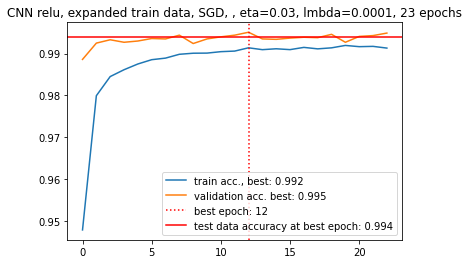

acc [0.9477959871292114, 0.9799119830131531, 0.9844920039176941, 0.9861279726028442, 0.9875040054321289, 0.9885320067405701, 0.9889079928398132, 0.9898239970207214, 0.9900799989700317, 0.9901080131530762, 0.990451991558075, 0.9905920028686523, 0.9913759827613831, 0.9909319877624512, 0.9911440014839172, 0.9909399747848511, 0.9914759993553162, 0.9911239743232727, 0.9913679957389832, 0.9919440150260925, 0.9916480183601379, 0.9917200207710266, 0.9913079738616943]
loss [0.3393710255622864, 0.213053897023201, 0.17302878201007843, 0.14758318662643433, 0.12867259979248047, 0.11363900452852249, 0.10392400622367859, 0.0947248637676239, 0.08845014125108719, 0.08492020517587662, 0.08134227991104126, 0.07865183055400848, 0.0752393901348114, 0.07417799532413483, 0.0734705850481987, 0.07312706857919693, 0.07205162942409515, 0.07195760309696198, 0.07144142687320709, 0.0694158524274826, 0.06964868307113647, 0.06950430572032928, 0.06989268213510513]
val_acc [0.9886000156402588, 0.9925000071525574, 0.993

In [11]:
################################################################
#   relu CNN network as described in chapter 6
################################################################
tf.random.set_seed(42)
# tf.random.set_seed(24)
################################################################


#################################
#    h-param base line
#################################
lmbda = 0.1 / 10 / 10 / 10
eta = 0.03
n_eph = 40

batch_size = 10
n_eph = 23




################################################################
print('lmbda= {}\n'.format(lmbda))
print('eta= {}\n'.format(eta))
print('n_eph= {}\n'.format(n_eph))
print('batch_size= {}\n'.format(batch_size))
print('n_eph= {}\n'.format(n_eph))
################################################################


################################################################
# construct netwoek model
input_shape = (28, 28, 1)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D( # no padding
        20,
        (5,5),
        activation=tf.nn.relu,
        kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda),
        input_shape=input_shape))

model.add(tf.keras.layers.MaxPool2D(strides=(2,2)))

model.add(tf.keras.layers.Conv2D( # no padding
        40,
        (5,5),
        activation=tf.nn.relu,
        kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda)))

model.add(tf.keras.layers.MaxPool2D(strides=(2,2)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(
        1000,
        activation=tf.nn.relu,
        kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda)))

model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(
        1000,
        activation=tf.nn.relu,
        kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda)))

model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10,activation=tf.nn.softmax))
################################################################

################################################################
# compile model
model.compile(
    optimizer=tf.keras.optimizers.SGD(
        learning_rate=eta,
        momentum=0.0,
        nesterov=False,
        name="SGD"),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

################################################################

model.summary()

################################################################
# save the model when val_acc is best
checkpoint_filepath = r'C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\save_model\expansion\expansion'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
################################################################

################################################################
#    train model  (how do i randomize mini_batches?)


ts = time.time()
history = model.fit(
    train_x, train_y, 
    epochs=n_eph,
    batch_size=batch_size,
    validation_data=(val_x, val_y),
    callbacks=[model_checkpoint_callback],
    shuffle=True
)
te = time.time()

print('total time:', te - ts)


acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
################################################################


################################################################
#    load the weights for the best epoch (best val accuracy)
model.load_weights(checkpoint_filepath)

################################################################

################################################################
#    evaluate test data at the best epoch
[test_data_loss, test_data_accuracy] = model.evaluate(
    test_x, test_y,
    batch_size=len(test_x)
)
################################################################


plt.plot(acc, label='train acc., best: {:.3f}'.format(max(acc)))
plt.plot(val_acc, label='validation acc. best: {:.3f}'.format(max(val_acc)))
plt.title('CNN relu, expanded train data, SGD, , eta={}, lmbda={}, {} epochs'.format(eta, lmbda, n_eph))
plt.axvline(x=np.argmax(val_acc), c='r', ls=':', label='best epoch: {}'.format(np.argmax(val_acc)))
plt.axhline(y=test_data_accuracy, c='r', label='test data accuracy at best epoch: {:.3f}'.format(test_data_accuracy))
plt.legend()
plt.show()

Beep(1000, 100)


print('acc', acc)
print('loss', loss)
print('val_acc', val_acc)
print('val_loss', val_loss)

<h1>It took 2 hours to train, but even with drop out the network does not perform better than without the final dense layers. (max accuracy= 99.4%) <h1/>